# Imports

In [1]:
from Code_Ring_Network import CodeRingNetwork
from utilities import bimodal_exponential_noise, exponential, bimodal_gaussian_noise, sigmoid

import numpy as np
from scipy.signal import find_peaks
from scipy.stats import weightedtau
import matplotlib.pyplot as plt
import os
from itertools import combinations
%matplotlib inline
%cd experiments/

c:\Users\Robbie\Documents\Documents\Research\Code_Ring_Network\Code-Ring-Network\experiments


# Redefine some plotting functions to be interactive

In [2]:
def plot_activity(self, ax: plt.axis,
                    ring_inputs: np.ndarray, v: np.ndarray = [], u: np.ndarray = [],
                    z: np.ndarray = [], I_prime: np.ndarray = [], **plot_kwargs) -> None:
    '''
    Plots the time series of the variables involved with the ring layer.

    :param ax matplotlib.pyplot.axis: the axis object to plot on
    :param ring_inputs np.ndarray: "I"; the array of inputs into the ring layer
        ring_inputs determine the order of activation of the ring neurons
    :param v np.ndarray: the activation (v) series of each ring neuron
        If not being plotted, will be [].   
    :param u np.ndarray: the deactivation (u) series of each ring neuron
        If not being plotted, will be [].   
    :param z np.ndarray: the output (z) series of each ring neuron
        If not being plotted, will be [].   
    :param I_prime np.ndarray: the "effective input" (I') series of each ring neuron
        If not being plotted, will be [].   

    :returns: None
    '''
    # include 8 most active ring neurons in legend
    sorted_inputs = np.flip(np.argsort(ring_inputs.squeeze()))
    for i in sorted_inputs[:8]:
        color = self.COLOR_RANGE[i]
        if np.any(v):
            plt.plot(v[i], label=f'v_{i}', c=color, linestyle='dashed')
        if np.any(u):
            plt.plot(u[i], label=f'u_{i}', c=color, linestyle='dotted')
        if np.any(I_prime):
            plt.plot(I_prime[i], label=f"I'_{i}", c=color, linestyle='dashdot')
        if np.any(z):
            plt.plot(z[i], label=f'z_{i}', c=color, linestyle='solid')
    
    # add '_' to beginning of these labels in the legend so they're ignored
    # we want to ignore the later half of inputs for visual clarity so legend isn't too big
    for i in sorted_inputs[8:]:
        color = self.COLOR_RANGE[i]
        if np.any(v):
            plt.plot(v[i], label=f'_v_{i}', c=color, linestyle='dashed')
        if np.any(u):
            plt.plot(u[i], label=f'_u_{i}', c=color, linestyle='dotted')
        if np.any(I_prime):
            plt.plot(I_prime[i], label=f"_I'_{i}", c=color, linestyle='dashdot')
        if np.any(z):
            plt.plot(z[i], label=f'_z_{i}', c=color, linestyle='solid')

    # ax.legend(loc='upper right')
    try:
        max_t_steps = plot_kwargs['max_t_steps']
    except KeyError:
        max_t_steps = 700
        
    ax.set_xlim([0, max_t_steps])
    tick_range = np.arange(0,max_t_steps+100,100)
    ax.set_xticks(tick_range)
    ax.set_xticklabels(tick_range / 10)
    ax.set_ylim([-1, 1])
    ax.set_xlabel('t')
    ax.set_title('Variable Plots')
    lines = [plt.Line2D([0], [0], color='black', linewidth=1, linestyle=style) for style in ['dashed','dotted','dashdot','solid']]
    labels = ["v", "u", "r'","z"]
    try:
        if plot_kwargs['legend']:
            plt.legend(lines, labels)
    except KeyError:
        plt.legend(lines, labels)
    plt.axhline(y=0.0, c="black", linewidth=0.05)

In [3]:
def plot_final_doodle(self, ax: plt.axis,
                        xs: np.array, ys: np.array,
                        intersec_pts: np.ndarray,
                        individualize_plot: bool = True, **plot_kwargs) -> None:
    '''
    Plots the final doodle.

    :param ax matplotlib.pyplot.axis: the axis object to plot on
    :param xs np.array: array of x-coordinates over time
    :param ys np.array: array of y-coordinates over time
    :param intersec_pts np.ndarray: array of shape (t_steps, 2) with 
        the [x, y] coordinates of each intersection point of the doodle
    :param individualize_plot bool: whether the plot should be individualized to fit
        that specific doodle's range of outputs, include legend, etc. This should be 
        True for most cases, but False when using CodeRingNetwork.show_results().

    :returns: None
    '''
    # plot lines
    ax.plot(xs, ys, alpha=0.5, c='black')

    if individualize_plot:
        # plot final pen point
        ax.scatter(xs[0], ys[0], alpha=0.8, marker = 'o', c='black', label='Origin')
        # organize plot
        ax.set_xlim([plot_kwargs['xmin'],plot_kwargs['xmax']])
        ax.set_xlabel('x', fontsize = 14)
        ax.set_ylim([plot_kwargs['ymin'],plot_kwargs['ymax']])
        ax.set_ylabel('y', fontsize = 14)
        ax.set_box_aspect(1)
        ax.set_title('Final Output')
        ax.legend()
        intersec_point_size = 20
        
    else:
        intersec_point_size = 4

    # plot all intersection points (if any)
    if intersec_pts.any():
        ax.scatter(intersec_pts[:,0], intersec_pts[:,1],
                    color='red', marker='o', s=intersec_point_size,
                    label='Intersections')


In [4]:
def plot_results(self, xs: np.array, ys: np.array, intersec_pts: np.ndarray,
                    ring_inputs: np.array, v: np.ndarray, u: np.ndarray,
                    z: np.ndarray, I_prime: np.ndarray,
                    folder_name: str,
                    epoch: int, iteration: int, active_idx: int, winner_idx: int,
                    score: float, plot_gif, idx_folders, **plot_kwargs) -> None:
    '''
    Plots the final resulting doodle and the variable activity graph of the ring layer. 
        The plots are saved to directory: `folder_name`\\`epoch` if plot_gif is True.
        Else, they're just saved in `folder_name`.
    
    :param xs np.array: array of x-coordinates over time
    :param ys np.array: array of y-coordinates over time
    :param intersec_pts np.ndarray: array of shape (t_steps, 2) with 
        the [x, y] coordinates of each intersection point of the doodle
    :param ring_inputs np.array: the array of inputs into the ring layer
    :param v np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of v (activation) values of the ring layer. 
        If not being plotted, will be [].    
    :param u np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of u (deactivation) values of the ring layer. 
        If not being plotted, will be [].        
    :param z np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of z (output) values of the ring layer. 
        If not being plotted, will be [].        
    :param I_prime np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of I_prime (resource) values of the ring layer. 
        If not being plotted, will be [].
    :param folder_name str: the model instance's corresponding folder name
    :param epoch int: the current epoch
    :param iteration int: the current iteration within the current epoch
    :param active_idx int: the index of the active map neuron
    :param winner_idx int: the index of the winner map neuron
    :param score float: the score of the outputted doodle
    :param plot_gif bool: whether to plot a GIF for each episode. This is used to determine the trial's folder structure
    :param idx_folders bool: whether each active map neuron's iterations should be kept in a separate folder or not.
        NOTE: this gives greater clarity in the way one neuron may learn over time.

    :returns: None
    '''
    f, axs = plt.subplots(1, 2)
    plot_final_doodle(self, axs[0], xs, ys, intersec_pts, **plot_kwargs)
    plot_activity(self, axs[1], ring_inputs, v, u, z, I_prime, **plot_kwargs)

    f.suptitle(f'Epoch {epoch}, Iteration {iteration}\n\
                Score = {np.round(score,2)} | Active = {active_idx} | Winner = {winner_idx}',
                fontsize=12)
    f.tight_layout()
    
    if plot_gif:
        if not os.path.isdir(f'{folder_name}\\{epoch}'):
            os.makedirs(f'{folder_name}\\{epoch}')
        f.savefig(f'{folder_name}\\{epoch}\\plot_{self.id_string}_epoch{epoch}')
    elif idx_folders:
        if not os.path.isdir(f'{folder_name}\\neurons\\{active_idx}'):
            os.makedirs(f'{folder_name}\\neurons\\{active_idx}')
        f.savefig(f'{folder_name}\\neurons\\{active_idx}\\plot_{self.id_string}_idx{active_idx}_epoch{epoch}')
    else:
        if not os.path.isdir(f'{folder_name}\\plots'):
            os.makedirs(f'{folder_name}\\plots')
        f.savefig(f'{folder_name}\\plots\\plot_epoch{epoch}_iteration{iteration}_{self.id_string}')

    plt.show(f)


In [5]:
# CodeRingNetwork.plot_activity = plot_activity
CodeRingNetwork.plot_final_doodle = plot_final_doodle
CodeRingNetwork.plot_results = plot_results

# Parameters & Definitions

In [6]:
ring_neurons = 36
weight_RC_spread = 0.00001

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 36
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.0001

t_max = 70
max_t_steps = 700

# define pretraining arguments
pretrain_iterations = 300 * map_neurons_d1 * map_neurons_d2
pretrain_lr = 0.1
pretrain_map_sigma = 2

# define training arguments
train_epochs = 1000
train_init_lr = 0.1
train_lr_decay = 0.0
train_init_map_sigma = 2
train_nhood_decay = -0.001
train_init_delta = 1.0
delta_exp_decay_rate = -0.0025

# # define metric-specific arguments
metric_sigma_Q = 10
metric_nominal = False
metric_ideal_seq = np.array([0,90,180,270])

# define noise arguments
noise_num_high = 4
noise_num_low = ring_neurons - noise_num_high
noise_mean_low = 0.1
noise_mean_high = 0.6
noise_sigma_low = 0.1
noise_sigma_high = 0.4

min_activity_value = 0.2

In [7]:
crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_num_high=noise_num_high,
                    noise_num_low=noise_num_low,
                    noise_mean_low=noise_mean_low,
                    noise_mean_high=noise_mean_high,
                    noise_sigma_low=noise_sigma_low,
                    noise_sigma_high=noise_sigma_high)

ID string: 2024-07-07 123108355270


# Metric

In [8]:
def nominal_ang_dev_metric(code_activity, **metric_kwargs):
    n = len(code_activity)
    active_idxs = np.argwhere(code_activity > metric_kwargs['min_activity_value']).flatten()
    num_high = len(active_idxs)
    activity_order = np.flip(np.argsort(code_activity[active_idxs])) # decreasing order, because highest activity fires first
    effector_order = active_idxs[activity_order]
    delta_angle = 360 / n

    init_effector = effector_order[0]
    init_angle = init_effector * delta_angle

    # check if active zone wraps around past 0 deg. if so, break up chain into 2 parts before combining
    if init_angle + (num_high * delta_angle) > 350:
        # get how many steps in 1st part of chain
        steps_from_init_to_0 = (360 - init_angle) / delta_angle
        # get how many steps in 2nd part of chain
        steps_from_0_to_end = num_high - steps_from_init_to_0
        # then combine the two parts
        ideal_angles = np.concatenate((np.arange(init_angle, 360, step=delta_angle), 
                                    np.arange(0, (steps_from_0_to_end * delta_angle), step=delta_angle)))
    # else, active zone doesn't wrap around
    else:
        ideal_angles = np.arange(init_angle, (init_angle + (num_high * delta_angle)), step=delta_angle)

    effector_angles = effector_order * delta_angle
    devs = effector_angles - ideal_angles
    dev_sum = np.sum(np.abs(devs))
    print(dev_sum)
    score = exponential(dev_sum, rate=metric_kwargs['penalty_rate'], init_val=1)
    return score

In [9]:
def weighted_kendall_effectors(z_series, ideal_sequence, **metric_kwargs):
    peak_times = np.array([])

    for i in range(z_series.shape[0]):
        peak_time, peak_props = find_peaks(z_series[i,:], height=0.8)
        if peak_time.shape[0] == 1:
            peak_times = np.concatenate((peak_times, peak_time))
        elif peak_time.shape[0] == 0:
            peak_times = np.concatenate((peak_times, [-1]))
        else: # more than 1 peak for effector i
            print(f'Multiple peaks for neuron {i}: {peak_time}')
            max_peak = np.argmax(peak_props['peak_heights'])
            peak_times = np.concatenate((peak_times, peak_time[max_peak]))

    print('peak_times', peak_times)

    n = z_series.shape[0]
    ideal = np.ones(n) * -1
    ideal[ideal_sequence] = np.arange(len(ideal_sequence))
    # ideal = np.arange(1, n+1)
    # print('ideal', ideal)
    active_angles = np.argwhere(peak_times >= 0).flatten() * 360 / n
    # print('active angles', active_angles)
    weighted_taus = []
    for i in range(n):
        ideal_rolled = np.roll(ideal, i)
        wtd_tau_normd = (weightedtau(peak_times, ideal_rolled, rank=False, weigher=lambda x: 1 if (x*360/n) in active_angles else 0, additive=True).statistic + 1) / 2
        weighted_taus += [wtd_tau_normd]
    
    best_w_tau = np.max(weighted_taus)
    print('best wtau idx: ',  np.argmax(weighted_taus))
    score = sigmoid(best_w_tau, beta=metric_kwargs['score_beta'], mu=metric_kwargs['score_mu'])
    print('score', score)
    print('best_w_tau', best_w_tau)

    return score

In [10]:
def angle_metric(z_series, **metric_kwargs):
    peak_times = np.array([])

    for i in range(z_series.shape[0]):
        peak_time, _ = find_peaks(z_series[i,:], height=0.2) # return peak_times for each peak (if more than 1) and peak_properties
        if peak_time.shape[0] == 1:
            peak_times = np.concatenate((peak_times, peak_time.astype('int')))
        elif peak_time.shape[0] == 0:
            peak_times = np.concatenate((peak_times, [-1]))
        else: # more than 1 peak for effector i
            print(f'Multiple peaks for neuron {i}: {peak_time}')
            return 0.0
    
    n = z_series.shape[0]
    angle_diff = 360 / n
    num_active_ideal = len(metric_kwargs['ideal_seq'])

    if metric_kwargs['nominal']:
        effector_seq = np.argsort(peak_times) # sorts ascending, with all inactive effector idxs coming first
        active_angles = np.argwhere(peak_times > 0).flatten()
        angle_seq = effector_seq[np.isin(effector_seq, active_angles)] * 360 / n
    else:
        actual_peaktimes = np.sort(peak_times[np.where(peak_times >= 0)[0]]).astype('int')
        x1s = metric_kwargs['x_series'][actual_peaktimes]
        y1s = metric_kwargs['y_series'][actual_peaktimes]
        
        x2s = metric_kwargs['x_series'][actual_peaktimes+1]
        y2s = metric_kwargs['y_series'][actual_peaktimes+1]

        angle_seq = (np.degrees(np.arctan2((y2s - y1s), (x2s - x1s))) + 360) % 360

    if len(angle_seq) != len(metric_kwargs['ideal_seq']):
        return 0.0
    
    offsets = np.broadcast_to(np.arange(0,360,angle_diff), (num_active_ideal,n)).T
    base_shapes = np.broadcast_to(metric_kwargs['ideal_seq'], (n, num_active_ideal))
    all_shapes = (base_shapes + offsets) % 360

    abs_dist = np.abs(angle_seq - all_shapes)
    circ_dist = np.minimum(abs_dist, 360 - abs_dist)

    if metric_kwargs['use_final']:
        subscores = np.exp(-np.square(circ_dist) / (2 * (metric_kwargs['sigma_Q_final'] ** 2)))
    else:
        subscores = np.exp(-np.square(circ_dist) / (2 * (metric_kwargs['sigma_Q'] ** 2)))

    subscore_weights = np.exp(-metric_kwargs['penalty_factor'] * (subscores - 1)) / np.sum(np.exp(-metric_kwargs['penalty_factor'] * (subscores - 1)), axis=1).reshape(-1,1)
    
    all_scores = np.sum(subscores * subscore_weights, axis=1)

    score = np.max(all_scores)

    selected_ideal_shape = np.argmax(all_scores)

    print('selected shape=',selected_ideal_shape)

    # # get the idx of the first effector to activate - that's what our ideal sequence is centered around
    # roll_val = np.argmin(np.where(peak_times >= 0, peak_times, 9999)) # replace -1's with 9999 so we can use argmin
    # ideal_rolled = (metric_kwargs['ideal_seq'] + (roll_val * 360 / n)) % 360
    # abs_dist = np.abs(angle_seq - ideal_rolled)
    # circ_dist = np.minimum(abs_dist, 360 - abs_dist)
    # if metric_kwargs['use_final']:
    #     subscores = np.exp(-np.square(circ_dist) / (2 * (metric_kwargs['sigma_Q_final'] ** 2)))
    # else:
    #     subscores = np.exp(-np.square(circ_dist) / (2 * (metric_kwargs['sigma_Q'] ** 2)))
    #     print('subscores=',np.round(subscores,2))

    # subscore_weights = np.exp(-metric_kwargs['zeta'] * (subscores - 1)) / np.sum(np.exp(-metric_kwargs['zeta'] * (subscores - 1)))

    print('subscores=',np.round(subscores[selected_ideal_shape],4))
    print('weights=',np.round(subscore_weights[selected_ideal_shape],4))


    return score

# Angle Metric Testing

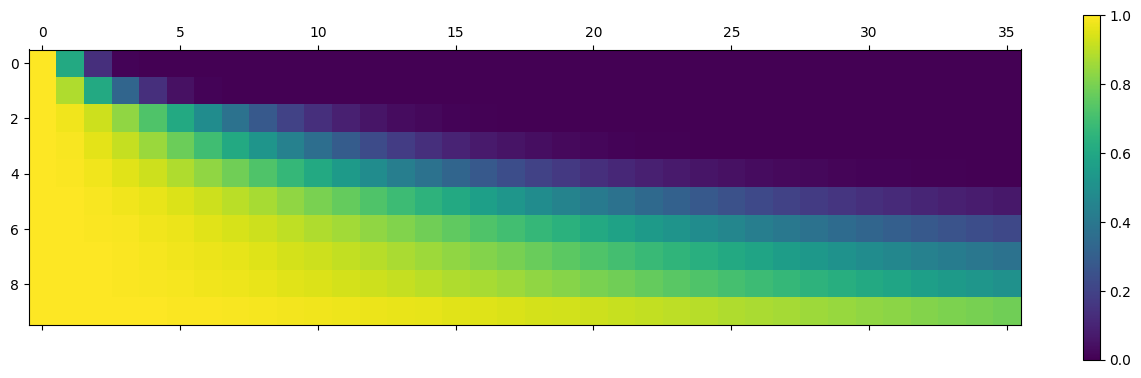

In [11]:
probs = np.zeros((10,36))
for delta_idx, sigma_delta in enumerate([1,2,5,7,10,15,20,25,30,50]):
    for dist_idx, dist in enumerate(range(36)):
        idvdl_gaussian = (np.exp(-np.square(dist) / (2 * (sigma_delta**2))))
        prob_selection = idvdl_gaussian #/ np.sum(idvdl_gaussian)
        probs[delta_idx][dist_idx] = prob_selection
plt.matshow(probs)
plt.colorbar()

c:\Users\Robbie\Documents\Documents\Research\Code_Ring_Network\Code-Ring-Network\Code_Ring_venv\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `event`.
  warn("The following arguments have no effect for a chosen solver: {}."


selected shape= 19
subscores= [0.6073 0.7211 0.9849 0.9926]
weights= [0.5367 0.3039 0.0812 0.0782]
selected shape= 17
subscores= [1.     0.98   0.7123 0.993 ]
weights= [0.136  0.1503 0.573  0.1408]
selected shape= 32
subscores= [0.6057 0.7268 0.5065 0.1662]
weights= [0.082  0.0448 0.1347 0.7385]
selected shape= 10
subscores= [1.     0.98   0.9842 0.9927]
weights= [0.2367 0.2616 0.2561 0.2455]
selected shape= 22
subscores= [0.6073 0.9803 0.5016 0.1661]
weights= [0.0838 0.013  0.1422 0.7611]
selected shape= 7
subscores= [0.6058 0.4945 0.7082 0.6791]
weights= [0.2477 0.4321 0.1484 0.1717]
selected shape= 6
subscores= [1.     0.98   0.9842 0.9927]
weights= [0.2367 0.2616 0.2561 0.2455]
selected shape= 28
subscores= [0.6057 0.9808 0.7125 0.993 ]
weights= [0.5308 0.0814 0.3113 0.0766]
selected shape= 27
subscores= [0.6057 0.7268 0.0985 0.1625]
weights= [0.0428 0.0234 0.5409 0.3929]
selected shape= 1
subscores= [1.     0.98   0.9842 0.6785]
weights= [0.1223 0.1352 0.1323 0.6102]
selected shap

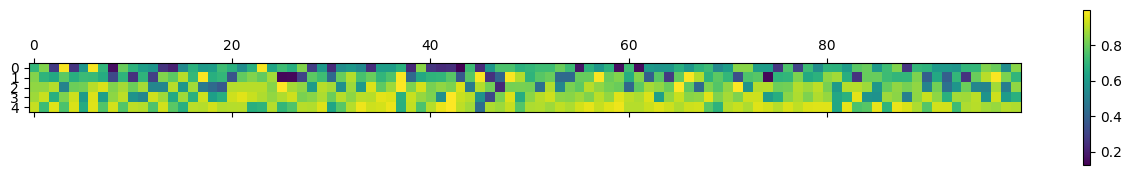

In [12]:
code_neuron_idxs = np.arange(0,crn.code_layer.num_code_units)
map_size = int(crn.map_layer.d1 * crn.map_layer.d2)
map_neuron_idxs = np.arange(map_size)

PLOTMINMAX = 20
sigma_Q = 20
sigma_delta = 1
penalty_factor = 5

ideal_seq = np.array([0,90,180,270])
num_active_ideal = len(ideal_seq)
k = crn.code_layer.num_code_units

# f, axs = plt.subplots(36,5,figsize=(50,25), sharex=True, sharey=True)

NUM_TRIALS = 100
# for sigma_delta in [3,2,1,0.5,0.1,0.01]:
scores = np.zeros((5,NUM_TRIALS))
# for r in range(n):
for q_idx, sigma_Q in enumerate([10,12,15,17,20]):
    for trial in range(NUM_TRIALS):   
        angle_diff = 360 / crn.code_layer.num_code_units
        r = np.random.randint(0, crn.code_layer.num_code_units)
        base_shape = (ideal_seq + (r * angle_diff)) % 360 
        high_idxs = (base_shape / angle_diff).astype('int')
        shape_signal = np.zeros(crn.code_layer.num_code_units)
        shape_signal[high_idxs] = np.linspace(1, 0.25, len(high_idxs))

        highest_shape_idxs = np.argpartition(shape_signal.flatten(), -num_active_ideal)[-num_active_ideal:]

        # compute the overall probability of each neuron from the multimodal gaussian distribution
        probs = np.zeros((crn.code_layer.num_code_units))
        available_codes = code_neuron_idxs
        selected = []
        for i in highest_shape_idxs:
            abs_dist = np.abs(code_neuron_idxs - i)
            circ_dist = np.minimum(abs_dist, k - abs_dist)
            idvdl_gaussian = ((shape_signal[i] / np.sum(shape_signal)) * np.exp(-np.square(circ_dist) / (2 * (sigma_delta**2))))
            # idvdl_gaussian = (np.exp(-np.square(circ_dist) / (2 * (sigma_delta**2))))
            prob_selection = idvdl_gaussian / np.sum(idvdl_gaussian)
            selected += [np.random.choice(code_neuron_idxs, 1, replace=False, p=prob_selection)]
            # probs = probs + idvdl_gaussian
        # normalize probabilities so they sum to 1
        # probs = probs / np.sum(probs)

        # select k random neurons from the multimodal distribution
        active_code_idxs = np.array(selected).reshape(num_active_ideal) # np.random.choice(code_neuron_idxs, num_active_ideal, replace=False, p=probs)
        # give those k neurons the highest map weights from the active map neuron
        code_input = np.zeros(crn.code_layer.num_code_units)
        # code_input[active_code_idxs] = map_activation[highest_map_idxs].flatten() 
        code_input[active_code_idxs] = shape_signal[highest_shape_idxs].flatten() 

        code_output = code_input

        # determine output of code layer (input into effector layer)
        ring_input = crn.code_layer.weights_to_ring_from_code @ code_output

        # determine activity of duration layer

        dur_output = crn.duration_layer.activate(0.2)

        # integrate ring layer model over time
        v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)

        # limit t_steps to end of integration
        t_steps = z_series.shape[1]

        # apply model results to the drawing system
        x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)

        # evaluate drawing
        # score, curvatures, intersec_pts, intersec_times = crn.evaluate(x_series, y_series, t_steps=t_steps, **metric_kwargs)
        score = angle_metric(z_series, ideal_seq=ideal_seq, sigma_Q=sigma_Q, nominal=False, x_series=x_series, y_series=y_series, use_final=False, penalty_factor=penalty_factor)
        scores[q_idx][trial] = score

        # crn.plot_final_doodle(ax=axs[r][q_idx], xs=x_series, ys=y_series, intersec_pts=np.array([]), individualize_plot=False)
        # axs[r][q_idx].set_xlim([-10,10])
        # axs[r][q_idx].set_ylim([-10,10])
        # axs[r][q_idx].set_xlabel(f'{np.round(score,3)}')
        # axs[r][q_idx].set_box_aspect(1)

        # plt.matshow(code_output.T.reshape(1,36),vmin=0,vmax=1)
        # plt.colorbar()
        # plt.title(f'score={score}')
        # plt.yticks([])

        # trial_scores.append(score)

        # get points for peak of each effector's activity
        # get peaks of z spikes
        max_times = np.argmax(z_series, axis=1).flatten()
        peak_vals = z_series[np.arange(crn.ring_layer.num_ring_units),max_times]
        active_idxs = np.argwhere(peak_vals > 0.1).flatten()
        act_mdpt_times = max_times[active_idxs]
        mdpts = np.vstack((x_series[act_mdpt_times], y_series[act_mdpt_times])).T
        midpts = np.empty(0) 

        # crn.plot_results(x_series, y_series, midpts, ring_input, v=v_series, u=u_series, z=z_series, I_prime=I_prime_series, folder_name=crn.folder_name, epoch=-1, iteration=-1, active_idx=-1, winner_idx=-1, score=score, plot_gif=False, idx_folders=False, xmin=-PLOTMINMAX, xmax=PLOTMINMAX, ymin=-PLOTMINMAX, ymax=PLOTMINMAX)
        # print(np.round(probs,3))
    # print(f'sigma_delta={sigma_delta} for {NUM_TRIALS} trials: Avg score={np.round(np.mean(scores),3)}; Percent perfect={np.count_nonzero(np.array(scores)>0.99)/NUM_TRIALS}; Percent learned={np.count_nonzero(np.array(scores)>0.1)/NUM_TRIALS}')
    # scores[r][q_idx] = np.mean(trial_scores)
# plt.tight_layout()
plt.matshow(scores)
plt.colorbar()

c:\Users\Robbie\Documents\Documents\Research\Code_Ring_Network\Code-Ring-Network\Code_Ring_venv\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `event`.
  warn("The following arguments have no effect for a chosen solver: {}."


selected shape= 26
subscores= [0.     0.0039 0.0039 1.    ]
weights= [0.3347 0.3296 0.3296 0.0061]
selected shape= 26
subscores= [0.000e+00 5.000e-04 2.170e-02 9.251e-01]
weights= [0.3402 0.3395 0.3119 0.0084]
nominal score= 0.009 empirical score= 0.015


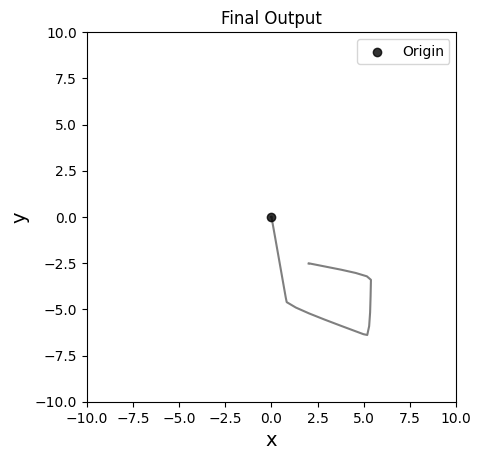

In [13]:
sigma_Q = 3
sigma_delta = 1
penalty_factor = 4
plot_minmax = 10

ideal_seq = np.array([0,90,180,270])

code_output = crn.ordered_shape_generator(ideal_seq=ideal_seq, sigma_delta=sigma_delta)

ring_input = (crn.code_layer.weights_to_ring_from_code @ code_output).squeeze()

# determine activity of duration layer
# TODO: right now, this is just a constant
dur_output = crn.duration_layer.activate(0.2)

# integrate ring layer model over time
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)

# limit t_steps to end of integration
t_steps = z_series.shape[1]

# apply model results to the drawing system
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)

# evaluate drawing
nom_score = angle_metric(z_series, x_series=x_series, y_series=y_series, use_final=False, sigma_Q=sigma_Q, nominal=True, ideal_seq=ideal_seq, penalty_factor=penalty_factor)
emp_score = angle_metric(z_series, x_series=x_series, y_series=y_series, use_final=False, sigma_Q=sigma_Q, nominal=False, ideal_seq=ideal_seq, penalty_factor=penalty_factor)

f, ax = plt.subplots(1)
print('nominal score=',np.round(nom_score,3), 'empirical score=',np.round(emp_score,3))
plot_final_doodle(crn, ax, x_series, y_series, intersec_pts=np.empty(0), xmin=-plot_minmax, xmax=plot_minmax, ymin=-plot_minmax, ymax=plot_minmax)


# Theoretical vs Empirical Doodle Testing Area

# Effector Parameter Adjusting

In [14]:
ring_neurons = 36
weight_RC_spread = 0.00002

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 36
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.00001

t_max = 70
max_t_steps = 7000

min_activity_value = 0.2

noise_num_low = 27
noise_num_high = 9
noise_mean_low = 0.1
noise_mean_high = 0.6
noise_sigma_low = 0.2
noise_sigma_high = 0.4

score_beta = 80
score_mu = 0.8

crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_num_high=noise_num_high,
                    noise_num_low=noise_num_low,
                    noise_mean_low=noise_mean_low,
                    noise_mean_high=noise_mean_high,
                    noise_sigma_low=noise_sigma_low,
                    noise_sigma_high=noise_sigma_high)


ID string: 2024-07-07 123123364675


### Testing alpha (momentum)
Decision: change alpha to 0.5

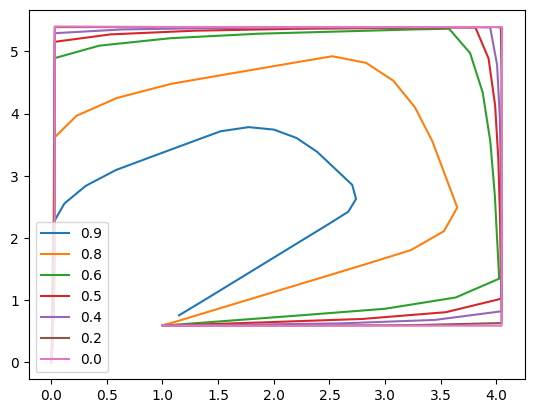

In [15]:
PLOT_MINMAX = 20
crn.ring_layer.alpha = 0.9
crn.ring_layer.psi = 1.2

# c1 - baseline parameters
c1 = np.zeros(crn.ring_layer.num_ring_units)
c1[[9,0,27,18]] = np.linspace(1,0.5,len([9,0,27,18]))
score = 0.0

# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.5], np.zeros(3))))

code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.8

# c2 - alpha=0.8
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.6

# c2 - alpha=0.7
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.5

# c2 - alpha=0.5
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.4

# c2 - alpha=0.4
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.2

# c2 - alpha=0.2
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

crn.ring_layer.alpha = 0.0

# c2 - alpha=0.0
# c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.85], np.zeros(3), [0.8], np.zeros(3), [0.75], np.zeros(3), [0.7], np.zeros(3), [0.65], np.zeros(3), [0.6], np.zeros(3), [0.55], np.zeros(3), [0.54], np.zeros(3))))
code_output = np.where(c1 >= min_activity_value, c1, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
# crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, I_prime_series, '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')

plt.legend(loc='lower left')

### Fix the shorter durations of later effectors
decision: leave psi at 1.2 because increasing it makes the v-waves oscillate too hard

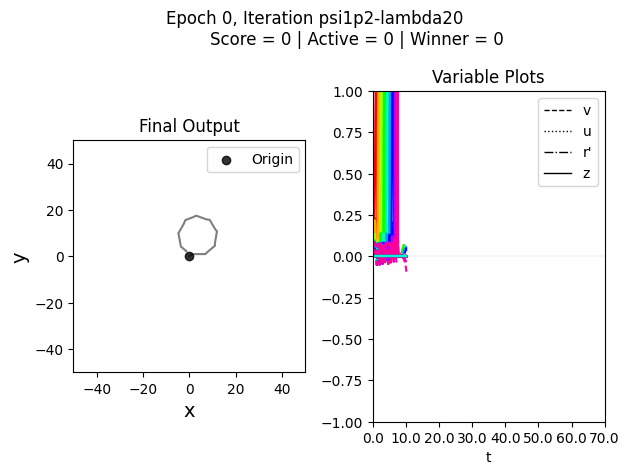

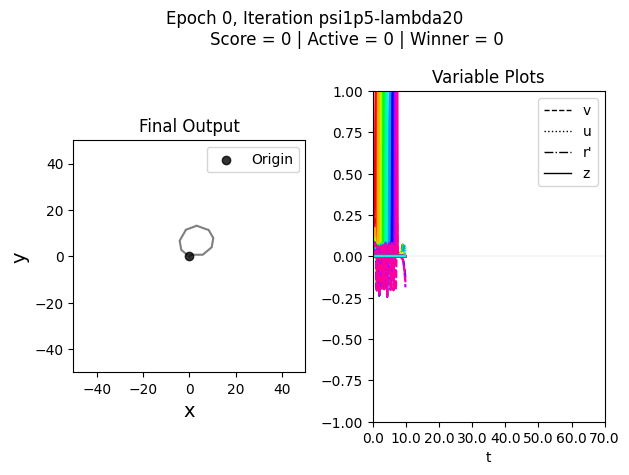

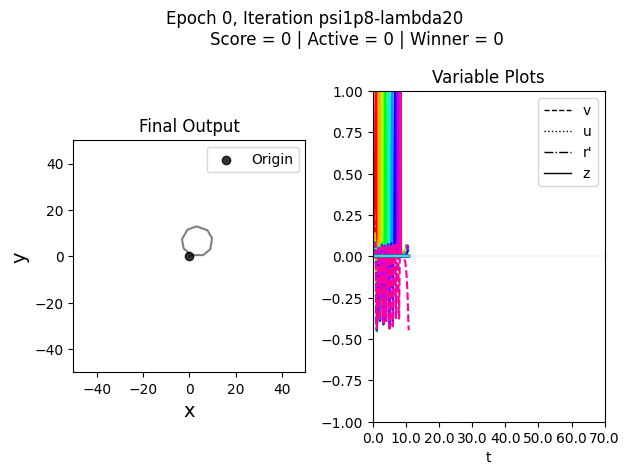

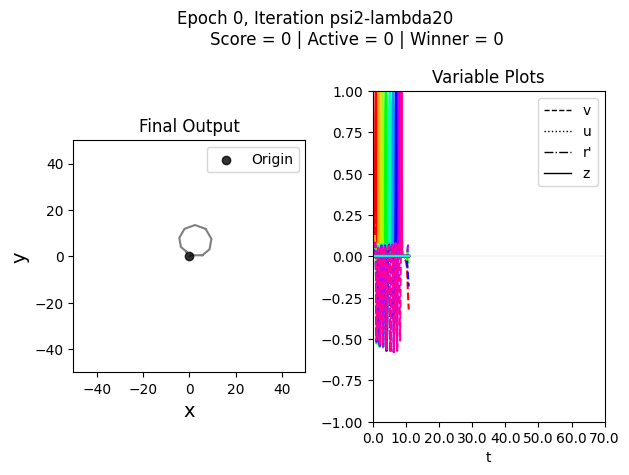

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


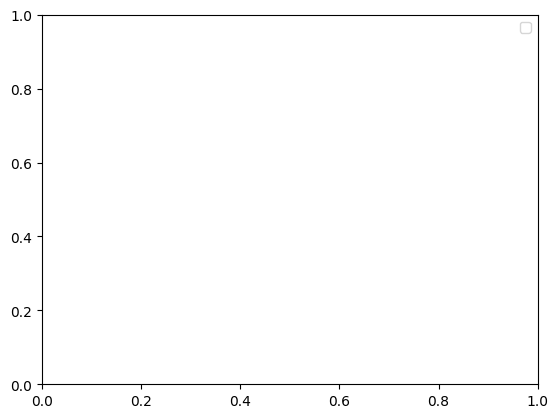

In [16]:
crn.ring_layer.psi = 1.2 # 1.2. lateral inhibition in dvdt eqn

PLOT_MINMAX = 50

c1 = np.array(np.concatenate(([0.9], np.zeros(3), [0.89], np.zeros(3), [0.88], np.zeros(3), [0.87], np.zeros(3), [0.86], np.zeros(3), [0.85], np.zeros(3), [0.84], np.zeros(3), [0.83], np.zeros(3), [0.82], np.zeros(3))))

for psi in [1.2,1.5,1.8,2]:
        try:
            crn.ring_layer.psi = psi

            code_output = np.where(c1 >= min_activity_value, c1, 0.0)
            ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
            dur_output = crn.duration_layer.activate(durs)
            v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
            t_steps = z_series.shape[1]
            x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
            crn.plot_results(x_series, y_series, np.array([]), ring_input, v_series, [], z_series, [], '', 0, f'psi{crn.ring_layer.psi}-lambda{crn.ring_layer.lambda_}'.replace('.','p'), 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

            # plt.plot(x_series, y_series, label=f'{crn.ring_layer.alpha}')
        except TypeError:
            pass

plt.legend()

# Effector Layer Studies

In [17]:
ring_neurons = 36
weight_RC_spread = 0.00002

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 36
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.00001

t_max = 70
max_t_steps = 700

min_activity_value = 0.2

noise_num_low = 27
noise_num_high = 9
noise_mean_low = 0.1
noise_mean_high = 0.6
noise_sigma_low = 0.2
noise_sigma_high = 0.4

score_beta = 80
score_mu = 0.8

crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_num_high=noise_num_high,
                    noise_num_low=noise_num_low,
                    noise_mean_low=noise_mean_low,
                    noise_mean_high=noise_mean_high,
                    noise_sigma_low=noise_sigma_low,
                    noise_sigma_high=noise_sigma_high)

ID string: 2024-07-07 123127688698


## Nominal Doodle vs Empirical Doodle Study
Place a line segment at the peak of each effector's activity. Orient the segment based on the effector's preferred direction. Line segment length determined by splitting the total doodle length by the number of neurons that spike.

In [18]:
def get_nominal_doodle(code_output, total_doodle_length):
    num_segments = np.count_nonzero(code_output > 0.2)
    segment_length = total_doodle_length / num_segments
    x_segments = [0]
    y_segments = [0]
    for i in np.flip(np.argsort(code_output)):
        if code_output[i] >= min_activity_value:
            x, y = crn.ring_layer.headings[i]
            x_segments += [x * segment_length]
            y_segments += [y * segment_length]
    x_series = np.cumsum(x_segments)
    y_series = np.cumsum(y_segments)

    return (x_series, y_series)

In [19]:
np.argwhere(code_output>0).flatten()

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32], dtype=int64)

selected shape= 0
subscores= [1.     0.7987 0.8381 0.9217]
weights= [0.1535 0.3433 0.2933 0.2099]


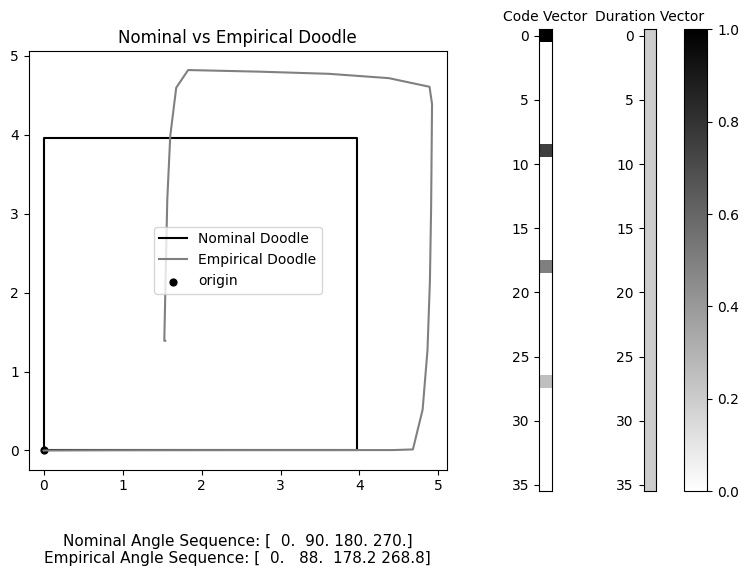

In [20]:
PLOTMINMAX = 20

code_output = np.zeros(crn.code_layer.num_code_units)
# code_output[[0,1,2,3]] = np.linspace(1,0.25,4) # counterclockwise primitive
# code_output[[35,34,33,32]] = np.linspace(1,0.25,4) # clockwise primitive
code_output[[0,9,18,27]] = np.linspace(1,0.25,4) # counterclockwise square
# code_output[np.arange(35,-1,-6)] = np.linspace(1,0.25,6) # hexagon
# code_output[[9,28,7,30,5,32,3,34,1,0]] = np.linspace(1,0.25,10) # wave
# code_output[[18,15,12,9,6,3,7,28,0,8,29,30,27,26,24]] = np.linspace(1,0.25,15) # cat

# determine output of code layer (input into ring layer)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output

# determine activity of duration layer
# TODO: right now, this is just a constant
dur_output = crn.duration_layer.activate(0.2)
# dur_output = np.zeros(crn.duration_layer.num_dur_units) + 0.
# dur_output[np.argwhere(code_output>0).flatten()] = [0.2, 0.2, 0.2, 0.2] # baseline 0.2
# dur_output[np.argwhere(code_output>0).flatten()] = [0.65, 0.7, 0.55, 0.4] # good square
# dur_output[[0,9,18,27]] = [0.2,0.2,0.15,0.15]

# integrate ring layer model over time
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps, cutoff=True)

# limit t_steps to end of integration
t_steps = z_series.shape[1]

# apply model results to the drawing system
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)

# evaluate drawing
score = angle_metric(z_series, ideal_seq=ideal_seq, sigma_Q=sigma_Q, nominal=False, x_series=x_series, y_series=y_series, use_final=False, penalty_factor=penalty_factor)

peak_times = np.array([])

for i in range(z_series.shape[0]):
    peak_time, _ = find_peaks(z_series[i,:], height=0.4) # return peak_times for each peak (if more than 1) and peak_properties
    if peak_time.shape[0] == 1:
        peak_times = np.concatenate((peak_times, peak_time.astype('int')))
    elif peak_time.shape[0] == 0:
        peak_times = np.concatenate((peak_times, [-1]))
    else: # more than 1 peak for effector i
        print(f'Multiple peaks for neuron {i}: {peak_time}')
        continue

k = z_series.shape[0]
angle_diff = 360 / k
num_active_ideal = len(code_input)

# get empirical angle sequence
actual_peaktimes = np.sort(peak_times[np.where(peak_times >= 0)[0]]).astype('int')
x1s = x_series[actual_peaktimes]
y1s = y_series[actual_peaktimes]

x2s = x_series[actual_peaktimes+1]
y2s = y_series[actual_peaktimes+1]

angle_seq = (np.degrees(np.arctan2((y2s - y1s), (x2s - x1s))) + 360) % 360

# crn.plot_results(x_series, y_series, midpts, ring_input, v=v_series, u=u_series, z=z_series, I_prime=I_prime_series, folder_name=crn.folder_name, epoch=-1, iteration=-1, active_idx=-1, winner_idx=-1, score=score, plot_gif=False, idx_folders=False, xmin=-PLOTMINMAX, xmax=PLOTMINMAX, ymin=-PLOTMINMAX, ymax=PLOTMINMAX)

# get nominal angle sequence
effector_seq = np.argsort(peak_times) # sorts ascending, with all inactive effector idxs coming first
active_angles = np.argwhere(peak_times > 0).flatten()
nom_angle_seq = effector_seq[np.isin(effector_seq, active_angles)] * 360 / k

# get nominal doodle
nom_x_series, nom_y_series = get_nominal_doodle(code_output, crn.calc_doodle_len(x_series, y_series))


f, axs = plt.subplots(1,3, figsize=(9,6), gridspec_kw={
                            'width_ratios': [3,1,1],
                            'wspace': 0.0,
                            'hspace': 0.0})

axs[0].plot(nom_x_series, nom_y_series, c='black', label='Nominal Doodle')
axs[0].plot(x_series, y_series, c='gray', label='Empirical Doodle')
# axs[0].set_xlim((-1,PLOTMINMAX))
# axs[0].set_ylim((-1,PLOTMINMAX))
axs[0].set_title('Nominal vs Empirical Doodle')
axs[0].scatter([0],[0],c='black',s=24,label='origin')
axs[0].legend()

img1 = axs[1].matshow(code_output.reshape(-1,1), cmap='binary', vmin=0, vmax=1)
axs[1].set_xticks([])
axs[1].set_title('Code Vector', fontsize=10)

img2 = axs[2].matshow(dur_output.reshape(-1,1), cmap='binary', vmin=0, vmax=1)
axs[2].set_xticks([])
axs[2].set_title('Duration Vector', fontsize=10)

axs[0].set_xlabel(f'\n\nNominal Angle Sequence: {nom_angle_seq}\nEmpirical Angle Sequence: {np.array_str(angle_seq, precision=1, suppress_small=True)}',fontsize=11)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_box_aspect(1)
plt.colorbar(img1, ax=axs[1:3], pad=0.1)

(0.0, 100.0)

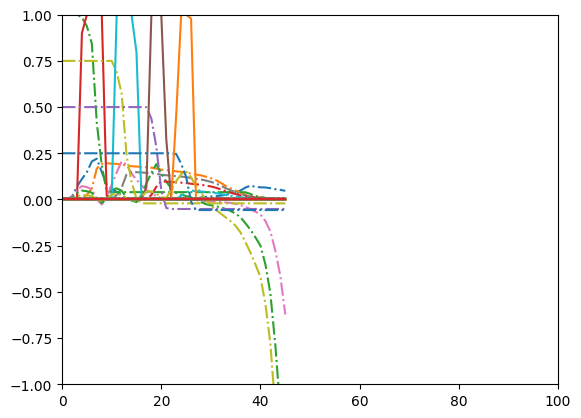

In [21]:
for i in range(len(ring_input)):
    plt.plot(v_series[i], label=f'v_{i}', linestyle='dashdot')
    plt.plot(u_series[i], label=f'u_{i}', linestyle='dashdot')
    plt.plot(I_prime_series[i], label=f"r_{i}", linestyle='dashdot')
    plt.plot(z_series[i], label=f'z_{i}', linestyle='solid')
plt.ylim([-1,1])
plt.xlim([0,100])

## Show robustness to changing input distributions that preserve the sequence

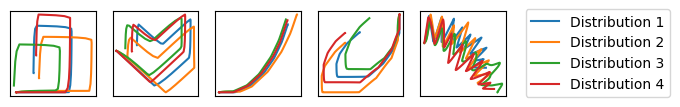

In [22]:
PLOT_MINMAX = 20

f, axs = plt.subplots(1, 5)

c1 = np.zeros(crn.code_layer.num_code_units)

c1s = [np.linspace(1,0.25,4),
       np.linspace(1,0.7,4),
       np.linspace(0.35,0.25,4),
       [1]+list(np.linspace(0.7,0.5,2))+[0.25]]

for idx, c in enumerate(c1s):
    c1[[0,9,18,27]] = c
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    axs[0].plot(x_series, y_series, label=f'{idx}')
    axs[0].set_box_aspect(1)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

c2 = np.zeros(crn.code_layer.num_code_units)

c2s = [np.linspace(1,0.25,6),
       np.linspace(1,0.7,6),
       np.linspace(0.35,0.25,6),
       [1]+list(np.linspace(0.7,0.5,4))+[0.25]]

for idx, c in enumerate(c2s):
    c2[[30,6,9,24,12,27]] = c
    code_output = np.where(c2 >= min_activity_value, c2, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    axs[1].plot(x_series, y_series, label=f'{idx}')
    axs[1].set_box_aspect(1)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

c3 = np.zeros(crn.code_layer.num_code_units)

c3s = [np.linspace(1,0.25,6),
       np.linspace(1,0.7,6),
       np.linspace(0.35,0.25,6),
       [1]+list(np.linspace(0.7,0.5,4))+[0.25]]

for idx, c in enumerate(c3s):
    c3[[0,1,2,3,4,5]] = c
    code_output = np.where(c3 >= min_activity_value, c3, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    axs[2].plot(x_series, y_series, label=f'{idx}')
    axs[2].set_box_aspect(1)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

c4 = np.zeros(crn.code_layer.num_code_units)

c4s = [np.linspace(1,0.25,9),
       np.linspace(1,0.7,9),
       np.linspace(0.35,0.25,9),
       [1]+list(np.linspace(0.7,0.5,7))+[0.25]]

for idx, c in enumerate(c4s):
    c4[[27,26,25,24,18,9,8,7,6]] = c
    code_output = np.where(c4 >= min_activity_value, c4, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    axs[3].plot(x_series, y_series, label=f'{idx}')
    axs[3].set_box_aspect(1)
    axs[3].set_xticks([])
    axs[3].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

c5 = np.zeros(crn.code_layer.num_code_units)

c5s = [np.linspace(1,0.25,17),
       np.linspace(1,0.7,17),
       np.linspace(0.35,0.25,17),
       [1]+list(np.linspace(0.7,0.5,15))+[0.25]]

for idx, c in enumerate(c5s):
    c5[[8,28,7,27,6,26,5,25,4,24,3,23,2,22,1,21,0]] = c
    code_output = np.where(c5 >= min_activity_value, c5, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    axs[4].plot(x_series, y_series, label=f'Distribution {idx+1}')
    axs[4].set_box_aspect(1)
    axs[4].set_xticks([])
    axs[4].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)
plt.legend(bbox_to_anchor=(3,1.1))

## Show sensitivity to changes in sequence

In [23]:
def swap1(a):
    temp = a[0]
    a[0] = a[1]
    a[1] = temp
    return a

def swap2(a):
    temp = a[0]
    a[0] = a[-1]
    a[-1] = temp
    return a

def swap3(a):
    return [a[0]] + list(np.flip(a[1:-1])) + [a[-1]]

def swap4(a):
    return list(np.flip(a))

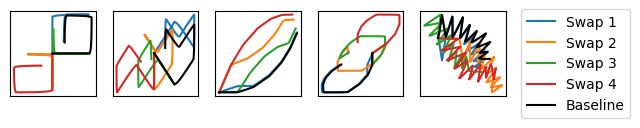

In [24]:
PLOT_MINMAX = 20

f, axs = plt.subplots(1, 5)

c1 = np.zeros(crn.code_layer.num_code_units)

baseline1 = list(np.linspace(1,0.25,4))
c1s = [swap1(baseline1.copy()),
       swap2(baseline1.copy()),
       swap3(baseline1.copy()),
       swap4(baseline1.copy()),
       baseline1]

for idx, c in enumerate(c1s):
    c1[[0,9,18,27]] = c
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    if idx == 4:
       axs[0].plot(x_series, y_series, label='Baseline', c='black')
    else:
       axs[0].plot(x_series, y_series, label=f'{idx}')
    
    axs[0].set_box_aspect(1)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

c2 = np.zeros(crn.code_layer.num_code_units)
baseline2 = np.linspace(1.0,0.25,6)
c2s = [swap1(baseline2.copy()),
       swap2(baseline2.copy()),
       swap3(baseline2.copy()),
       swap4(baseline2.copy()),
       baseline2,]

for idx, c in enumerate(c2s):
    c2[[30,6,9,24,12,27]] = c
    code_output = np.where(c2 >= min_activity_value, c2, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    if idx == 4:
       axs[1].plot(x_series, y_series, label='Baseline', c='black')
    else:
       axs[1].plot(x_series, y_series, label=f'{idx}')
    axs[1].set_box_aspect(1)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

c3 = np.zeros(crn.code_layer.num_code_units)
baseline3 = np.linspace(1.0,0.25,6)
c3s = [swap1(baseline3.copy()),
       swap2(baseline3.copy()),
       swap3(baseline3.copy()),
       swap4(baseline3.copy()),
       baseline3]

for idx, c in enumerate(c3s):
    c3[[0,1,2,3,4,5]] = c
    code_output = np.where(c3 >= min_activity_value, c3, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    if idx == 4:
       axs[2].plot(x_series, y_series, label='Baseline', c='black')
    else:
       axs[2].plot(x_series, y_series, label=f'{idx}')
    axs[2].set_box_aspect(1)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

c4 = np.zeros(crn.code_layer.num_code_units)
baseline4 = np.linspace(1.0,0.25,9)
c4s = [swap1(baseline4.copy()),
       swap2(baseline4.copy()),
       swap3(baseline4.copy()),
       swap4(baseline4.copy()),
       baseline4]

for idx, c in enumerate(c4s):
    c4[[27,26,25,24,18,9,8,7,6]] = c
    code_output = np.where(c4 >= min_activity_value, c4, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    if idx == 4:
       axs[3].plot(x_series, y_series, label='Baseline', c='black')
    else:
       axs[3].plot(x_series, y_series, label=f'{idx}')
    axs[3].set_box_aspect(1)
    axs[3].set_xticks([])
    axs[3].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)

c5 = np.zeros(crn.code_layer.num_code_units)
baseline5 = np.linspace(1.0,0.25,17)
c5s = [swap1(baseline5.copy()),
       swap2(baseline5.copy()),
       swap3(baseline5.copy()),
       swap4(baseline5.copy()),
       baseline5]

for idx, c in enumerate(c5s):
    c5[[8,28,7,27,6,26,5,25,4,24,3,23,2,22,1,21,0]] = c
    code_output = np.where(c5 >= min_activity_value, c5, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    if idx == 4:
       axs[4].plot(x_series, y_series, label='Baseline', c='black')
    else:
       axs[4].plot(x_series, y_series, label=f'Swap {idx+1}')
    axs[4].set_box_aspect(1)
    axs[4].set_xticks([])
    axs[4].set_yticks([])
    # crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)
plt.legend(bbox_to_anchor=(1.1,1.1))

## Theoretical vs Transitional vs Actual Doodles

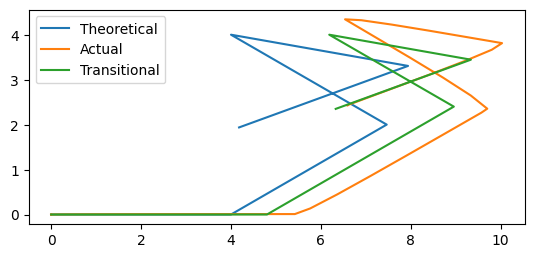

In [25]:
def get_theoretical_doodle(code_activity, segment_lengths):
    x_segments = [0]
    y_segments = [0]
    for i in np.flip(np.argsort(code_activity)):
        if code_activity[i] >= min_activity_value:
            x, y = crn.ring_layer.headings[i]
            x_segments += [x * segment_lengths]
            y_segments += [y * segment_lengths]
    x_series = np.cumsum(x_segments)
    y_series = np.cumsum(y_segments)

    return (x_series, y_series)

c = np.zeros(36)
c[[0,3,15,35,20]] = np.linspace(1,0.21,len([0,3,15,35,20]))
xs_thr, ys_thr = get_theoretical_doodle(c, 4)
plt.plot(xs_thr, ys_thr, label='Theoretical')

code_output = np.where(c >= min_activity_value, c, 0.0)
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs)
v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
plt.plot(x_series, y_series, label='Actual')

dom_idxs = np.argmax(z_series, axis=0)
# get transition times. anywhere the dominant index changes, but include endpoints too. 
# unique() in case the dominant idx changes at t=0 ot t_max
transition_times = np.unique(np.concatenate(([0], np.argwhere(np.diff(dom_idxs) != 0).flatten(), [z_series.shape[1]])))
xsegs_trns, ysegs_trns = [0], [0]
for t in range(z_series.shape[1]):
    dom_idx = dom_idxs[t]
    if z_series[dom_idx][t] > min_activity_value:
        xsegs_trns += [0.8*crn.ring_layer.headings[dom_idx,0]]
        ysegs_trns += [0.8*crn.ring_layer.headings[dom_idx,1]]

xs_trns = np.cumsum(xsegs_trns)
ys_trns = np.cumsum(ysegs_trns)
plt.plot(xs_trns, ys_trns, label='Transitional')
plt.legend()
plt.gca().set_aspect('equal')

# Determine Doodle Segment Lengths
Question: Is this inconsistent because of the integration method? Or due to model parameters?

Other issue: The length of doodle depends on the number of t_steps. Should each t_step be multiplied by dt?

48


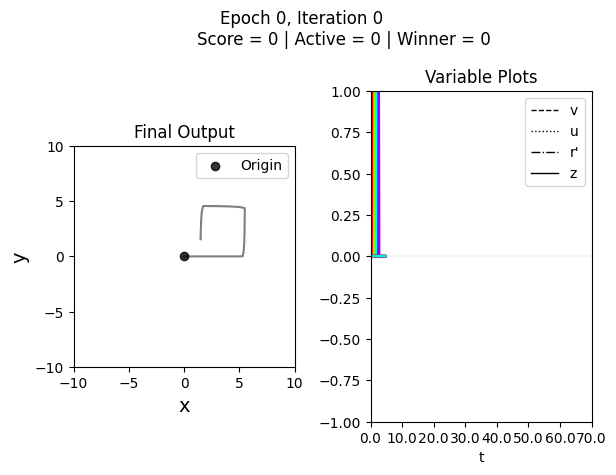

1.0: 16.476619781540915
48


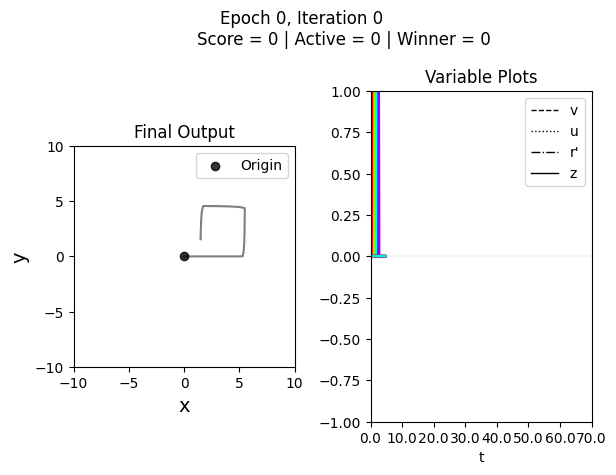

0.9233333333333333: 16.476619781540915
48


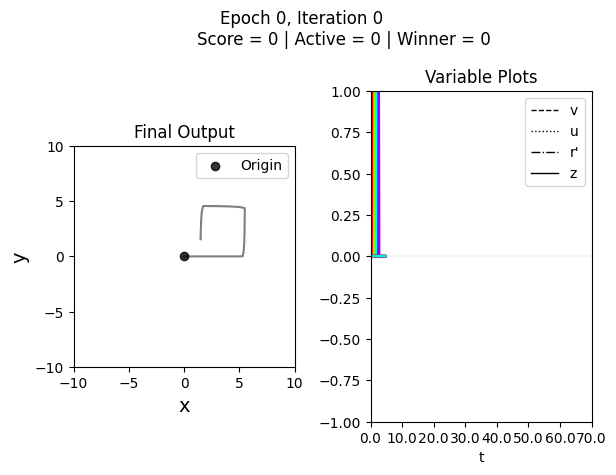

0.8466666666666667: 16.476619781540915
48


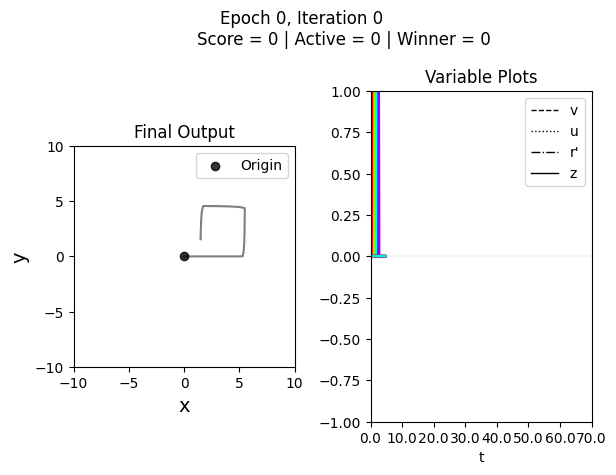

0.77: 16.476619781540915
48


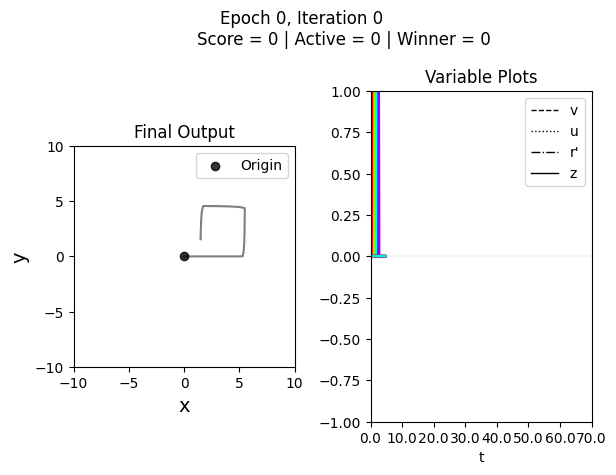

0.6933333333333334: 16.476619781540915
48


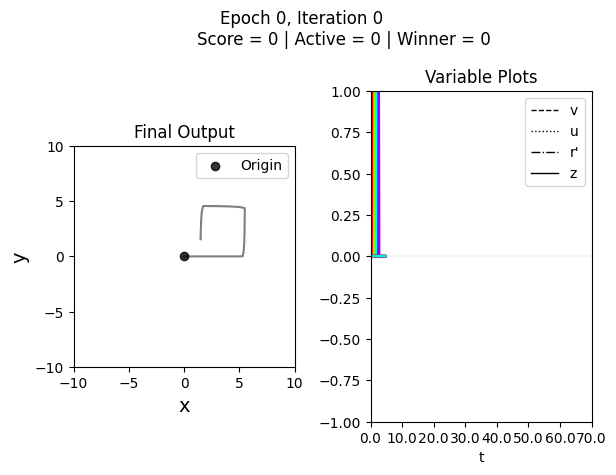

0.6166666666666667: 16.476619781540915
48


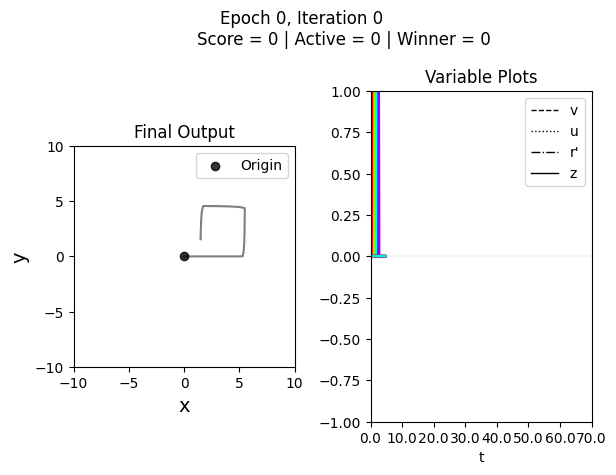

0.54: 16.476619781540915
48


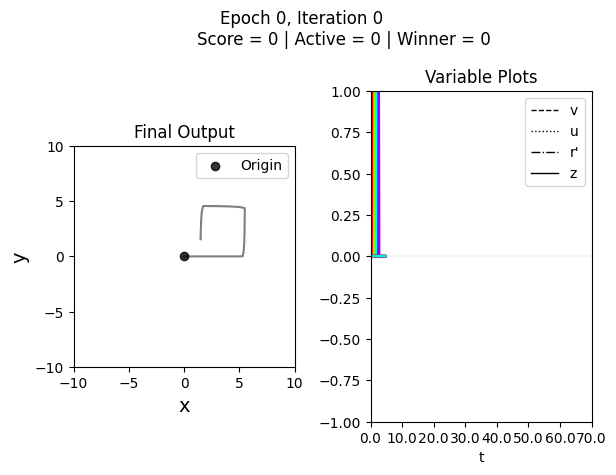

0.4633333333333334: 16.476619781540915
48


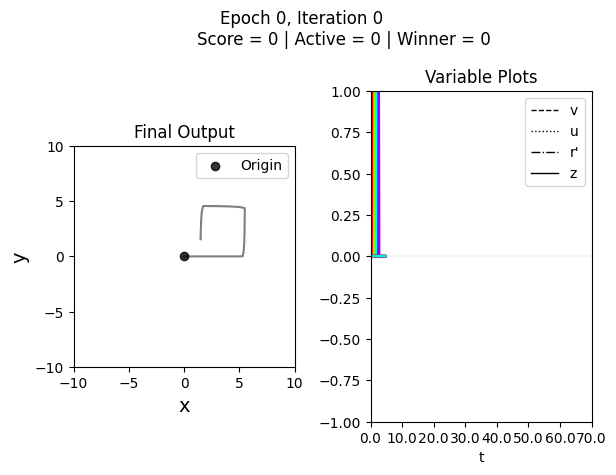

0.3866666666666667: 16.476619781540915
48


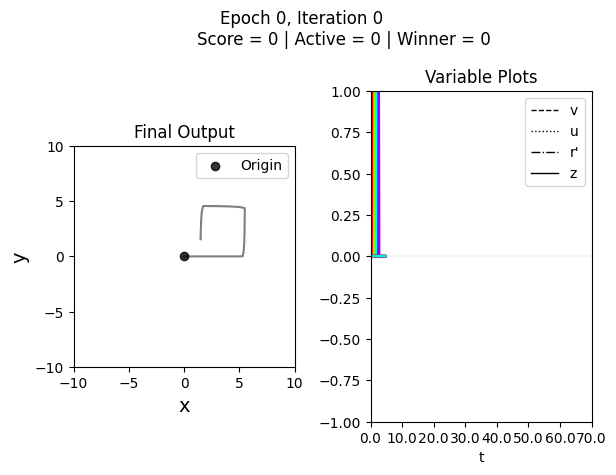

0.31: 16.476619781540915


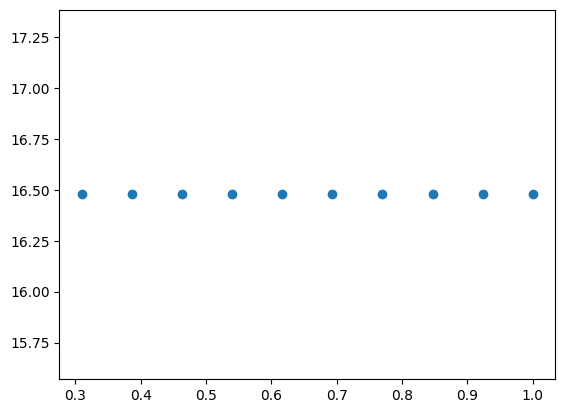

In [26]:
PLOT_MINMAX = 10

crn.ring_layer.psi = 1.2
crn.ring_layer.phi = 1.2
crn.ring_layer.beta = 200
crn.ring_layer.gamma = 0.1
cvals = np.linspace(1,0.31,10)
lens = []
for cval in cvals:
    c1 = np.zeros(crn.ring_layer.num_ring_units)
    c1[[0,9,18,27]] = np.linspace(1,0.21,len([0,9,18,27]))
    code_output = np.where(c1 >= min_activity_value, c1, 0.0)
    ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
    dur_output = crn.duration_layer.activate(durs)
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)
    t_steps = z_series.shape[1]
    print(t_steps)
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)
    crn.plot_results(x_series, y_series, np.array([]), ring_input, [], [], z_series, [], '', 0, 0, 0, 0, 0, False, False, xmin=-PLOT_MINMAX,xmax=PLOT_MINMAX, ymin=-PLOT_MINMAX, ymax=PLOT_MINMAX)
    print(f'{cval}: {crn.calc_doodle_len(x_series, y_series)}')
    lens += [crn.calc_doodle_len(x_series, y_series)]
plt.scatter(cvals, lens)




# Thesis Effector Parameter Plots

In [27]:
ring_neurons = 8
weight_RC_spread = 0.00002

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 8
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.00001

t_max = 70
max_t_steps = 700

min_activity_value = 0.2

noise_num_low = 0
noise_num_high = 8
noise_mean_low = 0.1
noise_mean_high = 0.6
noise_sigma_low = 0.2
noise_sigma_high = 0.4

score_beta = 80
score_mu = 0.8

crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_num_high=noise_num_high,
                    noise_num_low=noise_num_low,
                    noise_mean_low=noise_mean_low,
                    noise_mean_high=noise_mean_high,
                    noise_sigma_low=noise_sigma_low,
                    noise_sigma_high=noise_sigma_high)

ID string: 2024-07-07 123139129397


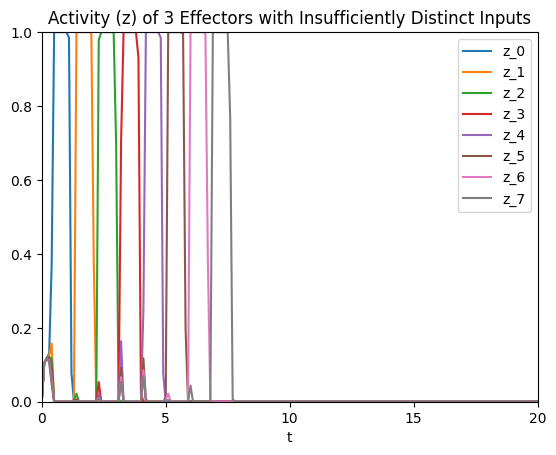

In [28]:
code_output = np.array([1.0, 0.99998, 0.99997,0.99996,0.99995,0.99994,0.99993,0.99992])
ring_input = crn.code_layer.weights_to_ring_from_code @ code_output
dur_output = crn.duration_layer.activate(durs) # np.array([0.2,0.3,0.4,0.5,0.6,0.7]) #
v_series, z_series, u_series, r_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps, cutoff=False)
t_steps = z_series.shape[1]
x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)

f, ax = plt.subplots(1,1)

plot_v = False
plot_u = False
plot_z = True
plot_r = False

plt_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i in range(len(ring_input)):
    if plot_v:
        plt.plot(v_series[i], label=f'v_{i}', c=plt_colors[i], linestyle='dashdot')
    if plot_u:
        plt.plot(u_series[i], label=f'u_{i}', c=plt_colors[i], linestyle='dashdot')
    if plot_r:
        plt.plot(r_series[i], label=f"r_{i}", c=plt_colors[i], linestyle='dashdot')
    if plot_z:
        plt.plot(z_series[i], label=f'z_{i}', c=plt_colors[i], linestyle='solid')

ax.legend(loc='upper right')
ax.set_xlim([0, 200])
ax.set_xticks([0,50,100,150,200])
ax.set_xticklabels(np.arange(0,25,5))
ax.set_ylim([0, 1])
ax.set_xlabel('t')
ax.set_title('Activity (z) of 3 Effectors with Insufficiently Distinct Inputs')
plt.axhline(y=0.0, c="black", linewidth=0.05)

# Thesis Chain Sequence of Map Activations Together

In [29]:
ring_neurons = 36
weight_RC_spread = 0.00002

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 36
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.00001

t_max = 70
max_t_steps = 700

min_activity_value = 0.2

noise_num_low = 27
noise_num_high = 9
noise_mean_low = 0.1
noise_mean_high = 0.6
noise_sigma_low = 0.2
noise_sigma_high = 0.4

score_beta = 80
score_mu = 0.8

crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_num_high=noise_num_high,
                    noise_num_low=noise_num_low,
                    noise_mean_low=noise_mean_low,
                    noise_mean_high=noise_mean_high,
                    noise_sigma_low=noise_sigma_low,
                    noise_sigma_high=noise_sigma_high)

ID string: 2024-07-07 123139612098


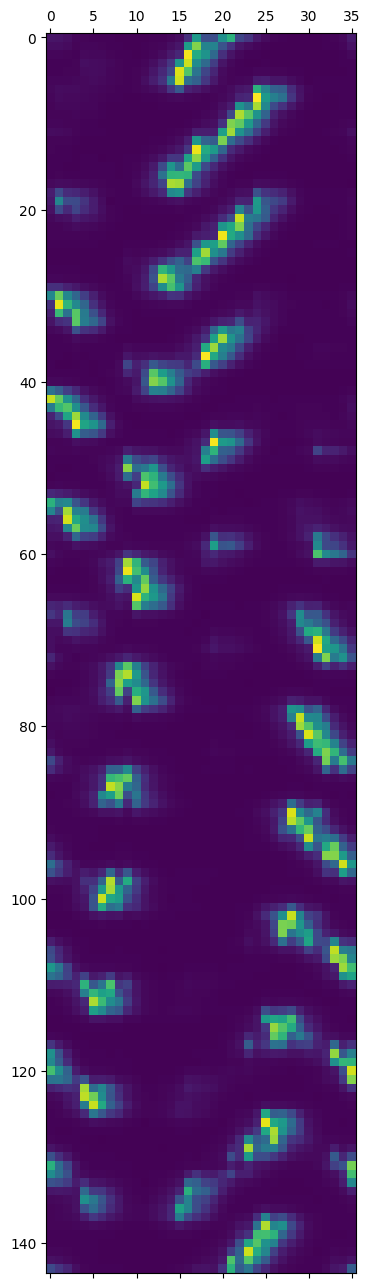

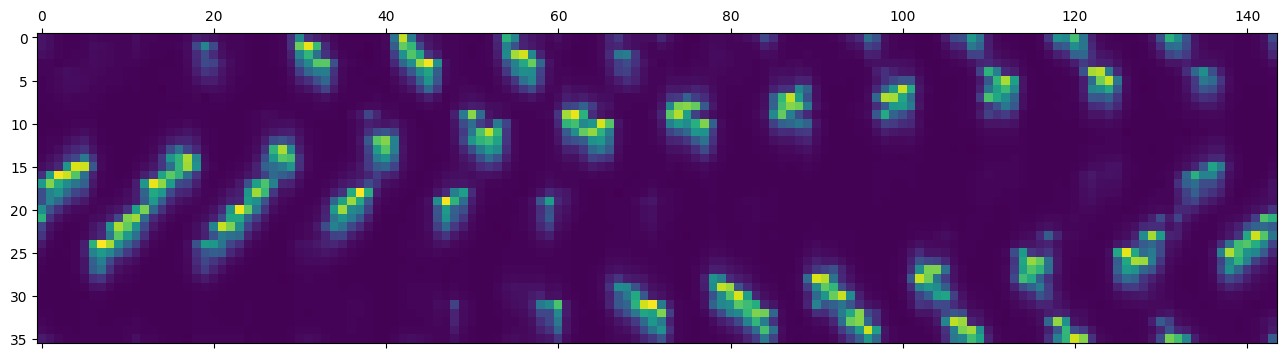

In [30]:
crn.map_layer.weights_to_code_from_map = crn.load_model_params("C:\\Users\\Robbie\\Documents\\Documents\\Research\\Code_Ring_Network\\Code-Ring-Network\\output\\2024-06-27 214555265439-primitive results\\weights_2024-06-27 214555265439.xlsx")
crn.map_layer.weights_to_map_from_code = crn.map_layer.weights_to_code_from_map.T
plt.matshow(crn.map_layer.weights_to_map_from_code)
plt.matshow(crn.map_layer.weights_to_code_from_map)

## Method 1
Compute a code vector by modulating the (highest?) weights of two map neurons. 

In [31]:
def linear_mapping(arr, des_max, des_min, eps):
    # get min and max of array (excluding zeros)
    min = np.min(arr[np.argwhere(arr > 0)])
    max = np.max(arr[np.argwhere(arr > 0)])
    # calculate slope (rise over run)
    slope = (des_max - des_min) / (max - min + eps)
    # calculate the y-intercept
    intercept = des_max - ((des_max - des_min) * max / (max - min + eps))
    # apply the linear function to all nonzero values. zeros stay the same.
    return np.where(arr > 0.0, (arr * slope) + intercept, 0.0)


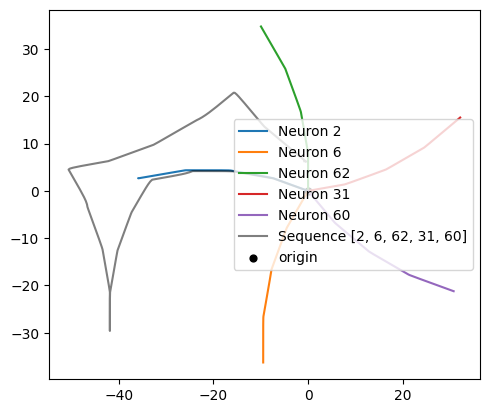

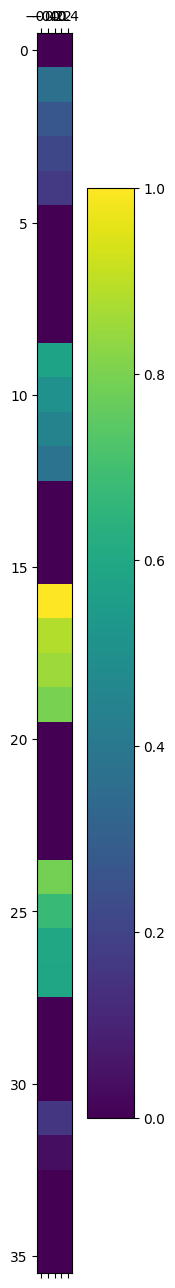

In [32]:
a = 0.3
i = 6
j = 49
k = 4

ms = [2,6,62,31,60]
code_dict = {}
c_merged = np.zeros(crn.ring_layer.num_ring_units)
des_max_init = 1
des_min_init = 0.8
for i, m_idx in enumerate(ms):
    m = crn.map_layer.weights_to_code_from_map[:,m_idx]
    top_k_idxs = np.argpartition(m.squeeze(), -k)[-k:]
    c = np.zeros((crn.ring_layer.num_ring_units))
    c[top_k_idxs] = m[top_k_idxs]

    code_dict[m_idx] = c
    des_max = des_max_init - (i * 0.21)
    des_min = des_min_init - (i * 0.21)

    ring_input = crn.code_layer.weights_to_ring_from_code @ c
    dur_output = crn.duration_layer.activate(0.2)
    v_series, z_series, u_series, r_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps, cutoff=False)
    t_steps = z_series.shape[1]
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)

    plt.plot(x_series, y_series, label=f'Neuron {m_idx}', alpha=1)

    c_merged = c_merged + linear_mapping(c, des_max, des_min, eps=0.00001)

ring_input_merged = crn.code_layer.weights_to_ring_from_code @ c_merged
dur_output_merged = crn.duration_layer.activate(0.2)
v_series_merged, z_series_merged, u_series_merged, r_series_merged = crn.ring_layer.activate(ring_input_merged, dur_output_merged, t_max=t_max, t_steps=max_t_steps, cutoff=False)
t_steps_merged = z_series_merged.shape[1]
x_series_merged, y_series_merged = crn.ring_layer.create_drawing(z_series_merged, t_steps_merged)

plt.plot(x_series_merged, y_series_merged, label=f'Sequence {list(code_dict.keys())}', c='black', alpha=0.5)
plt.scatter([0],[0],c='black',s=24,label='origin')
plt.gca().set_aspect(1)
plt.legend()
plt.matshow(c_merged.reshape(-1,1), vmin=0, vmax=1)
plt.colorbar()

## Method 2
Activate the Effector layer with 1 map neuron, preserve the state of the effectors and the canvas, and then activate with another map neuron.

### Redefine some functions to work with multiple map activations

In [33]:
from scipy.integrate import solve_ivp

In [34]:
def activate(self, input_from_code: np.ndarray, dur_outputs: np.ndarray,
                t_max: int, t_steps: int, cutoff: bool = True, init_state: np.ndarray = None) -> float:
    '''
    Applies the outputs of the code and duration layers into the ring layer to determine outputs of the ring layer.

    :param input_from_code np.ndarray: "I"; the array of outputs of the code layer, and inputs into the ring layer
        code_outputs determine the order of activation of the ring neurons        
    :param dur_outputs np.ndarray: "c"; the array of outputs of the duration layer, and inputs into the ring layer
        dur_outputs determine the duration that each ring neuron is activated
    :param t_max int: the maximum timestep to integrate to
    :param t_steps int: the number of timesteps to integrate over from [0, t_max]
    :param folder_name str: the model instance's corresponding folder name
    :param epoch int: the current epoch
    :param vars_to_plot dict: which of the 4 series should be plotted (v, u, z, I_prime)
        keys=the four series listed above, 
        values=bool indicating if each corresponding series should be plotted
    :param plot_results bool: whether a plot of the results should be created
    :param plot_gif bool: whether a GIF should be created of the drawing

    :returns score float: the metric score of the outputted drawing based on the metric function.
    '''
    if type(init_state) == type(None):
        # initialize activations and de-activations to 0
        v = np.zeros(self.num_ring_units)
        u = np.zeros(self.num_ring_units)

        input_from_code = input_from_code.squeeze()

        # create state vector out of the 3 vectors v, u, I so it's 1-D to work with solve_ivp()
        # state is initialized as [v_0, ... , v_N-1, u_0, ..., u_N-1, I_0, ..., I_N-1]
        # so, I' is initialized to I (AKA input_from_code)
        state = np.array((v, u, input_from_code)).reshape(3*self.num_ring_units)
    
    else:
        # use previous state
        init_state[int(2 * self.num_ring_units):] += input_from_code
        state = init_state

    # define our discretized timesteps
    t = np.linspace(0, t_max, t_steps)

    # integrate model over discretized timesteps
    if cutoff:
        result = solve_ivp(fun=lambda t, state: self.doodle(t, input_from_code, dur_outputs, state), t_span=(min(t), max(t)), dense_output=False, y0=state, event=self.stop_drawing)
    else:
        result = solve_ivp(fun=lambda t, state: self.doodle(t, input_from_code, dur_outputs, state), t_span=(min(t), max(t)), t_eval=t, y0=state)
        
    if not result.success:
        return 0
    v_series = result.y[:self.num_ring_units,]
    z_series = sigmoid(v_series, self.beta, self.mu)
    u_series = result.y[self.num_ring_units:2*self.num_ring_units,]
    I_prime_series = result.y[2*self.num_ring_units:,]

    return v_series, z_series, u_series, I_prime_series


In [35]:
def create_drawing(self, z_series: np.ndarray, t_steps: int, init_point: tuple = (0,0)) -> tuple:
    '''
    Applies the outputs of the model to create a doodle produced by the drawing mechanism.

    :param z_series np.ndarray: the series of z-values for each ring neuron
    :param t_steps int: the number of timesteps we integrated over

    :returns (xs, ys) tuple: tuple of the x_series and y_series of the pen (including momentum) 
    '''
    # calculate the activity in each direction over each timestep
    dir_series = z_series.T @ self.headings # does not include momentum
    momentum_term = np.roll(dir_series, 1, axis=0) # roll time series forward one step
    momentum_term[0, :] = np.array([0., 0.]) # set first momentum step to 0

    # get array of alphas to increasing powers
    # [0, alpha, alpha^2, alpha^3, ...]
    alphas = np.cumprod([self.alpha] * (t_steps - 1))
    alphas = np.array([0] + list(alphas))

    # recurrence relation boils down to the following momentum term
    # convolve(N, M) gives a result of n + m - 1 elements. we only need the first t_steps
    # TODO: turn the recurrence relation back to a loop. or maybe at least compare performance/time between the two
    xs_with_momentum = ((1 - self.alpha) * (z_series.T @ self.headings).T[0,:] +
                                    (1 - self.alpha) * np.convolve((z_series.T @ self.headings).T[0,:], alphas)[:t_steps])
    
    ys_with_momentum = ((1 - self.alpha) * (z_series.T @ self.headings).T[1,:] +
                                    (1 - self.alpha) * np.convolve((z_series.T @ self.headings).T[1,:], alphas)[:t_steps])

    # calculate cumulative location of pen over time
    x_series_with_momentum = [init_point[0]] + np.cumsum(xs_with_momentum)
    y_series_with_momentum = [init_point[1]] + np.cumsum(ys_with_momentum)

    return (x_series_with_momentum, y_series_with_momentum)


### Run chained sequence of map activations (all with same duration)

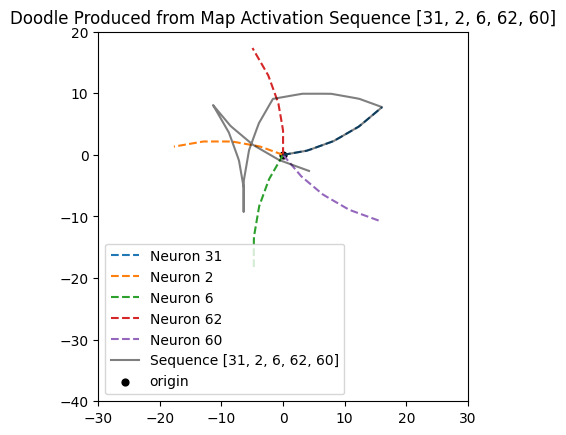

In [36]:
k = 4

f, ax = plt.subplots(1,1)

# ms = [2,6]
# ms = [6,2]
# ms = [2,6,31]
# ms = [62,2,6,60,31]
ms = [31,2,6,62,60]
# ms = [2,60,62,6,31]

code_dict = {}
c_merged = np.zeros(crn.ring_layer.num_ring_units)
for i, m_idx in enumerate(ms):
    # get top k indexes from current active map neuron
    m = crn.map_layer.weights_to_code_from_map[:,m_idx]
    top_k_idxs = np.argpartition(m.squeeze(), -k)[-k:]
    c = np.zeros((crn.ring_layer.num_ring_units))
    c[top_k_idxs] = m[top_k_idxs]

    # store the code vector so we can display it later
    code_dict[m_idx] = c

    # get ring inputs
    ring_input = crn.code_layer.weights_to_ring_from_code @ c
    dur_output = crn.duration_layer.activate(0.2)
    
    if i == 0:
        # activate the first map neuron
        v_series, z_series, u_series, r_series = activate(crn.ring_layer, ring_input, dur_output, t_max=t_max, t_steps=max_t_steps, cutoff=False, init_state=None)
        
        # store the final state from first map neuron as the next neuron's initial state
        next_init_state = np.array((v_series[:,-1], u_series[:,-1], r_series[:,-1])).reshape(3*crn.ring_layer.num_ring_units)
        
        # create the doodle for the first map neuron, starting at (0,0) on the canvas
        t_steps = z_series.shape[1]
        x_series, y_series = create_drawing(crn.ring_layer, z_series, t_steps, init_point=(0,0))

        # store the next map neuron's initial point
        next_init_point = (x_series[-1], y_series[-1])

        # plot current map neuron's doodle
        ax.plot(x_series/2, y_series/2, label=f'Neuron {m_idx}', alpha=1, linestyle='dashed')
    
    else:
        # activate next map neuron in sequence, using last map neuron's final state as the initial state
        v_series, z_series, u_series, r_series = activate(crn.ring_layer, ring_input, dur_output, t_max=t_max, t_steps=max_t_steps, cutoff=False, init_state=next_init_state)

        # store the final state from first map neuron as the next neuron's initial state 
        next_init_state = np.array((v_series[:,-1], u_series[:,-1], r_series[:,-1])).reshape(3*crn.ring_layer.num_ring_units)

        # create the doodle for the current map neuron, starting at the last map neuron's final point on the canvas
        t_steps = z_series.shape[1]
        x_series_new, y_series_new = create_drawing(crn.ring_layer, z_series, t_steps, init_point=next_init_point)

        x_series_origin, y_series_origin = create_drawing(crn.ring_layer, z_series, t_steps, init_point=(0,0))


        # store the next map neuron's initial point
        next_init_point = (x_series_new[-1], y_series_new[-1])

        # append the current map neuron's x and y series to the whole doodle's series
        x_series = np.hstack((x_series, x_series_new))
        y_series = np.hstack((y_series, y_series_new))

        ax.plot(x_series_origin/2, y_series_origin/2, label=f'Neuron {m_idx}', alpha=1, linestyle='dashed')

PLOT_MINMAX = 30

# plot entire sequence of doodles
ax.plot(x_series/2, y_series/2, label=f'Sequence {list(code_dict.keys())}', c='black', alpha=0.5)
ax.set_title(f'Doodle Produced from Map Activation Sequence {ms}')
ax.set_xlim([-PLOT_MINMAX,PLOT_MINMAX])
ax.set_ylim([-PLOT_MINMAX-10,PLOT_MINMAX-10])
ax.scatter([0],[0],c='black',s=24,label='origin')
ax.set_box_aspect(1)
ax.legend()
# f, axs = plt.subplots(1,len(ms), sharey=True)
# for i, m_idx in enumerate(ms):
#     img = axs[i].matshow(code_dict[m_idx].reshape(-1,1), vmin=0, vmax=1)
#     axs[i].set_xticks([])
#     axs[i].set_xlabel(f'Neuron {m_idx}', fontsize=8)
# f.colorbar(img, ax=axs.ravel().tolist(), pad=0.2)
# f.suptitle(f'All Code Vectors from Map Activation Sequence {ms}')
# f.supxlabel('Map Neurons')
# f.supylabel('Code Neurons')

### Run chained sequence of map activations (but vary durations between each map neuron's activity)
Note that for a given map neuron, all durations are the same. But that same value differs for each map neuron.

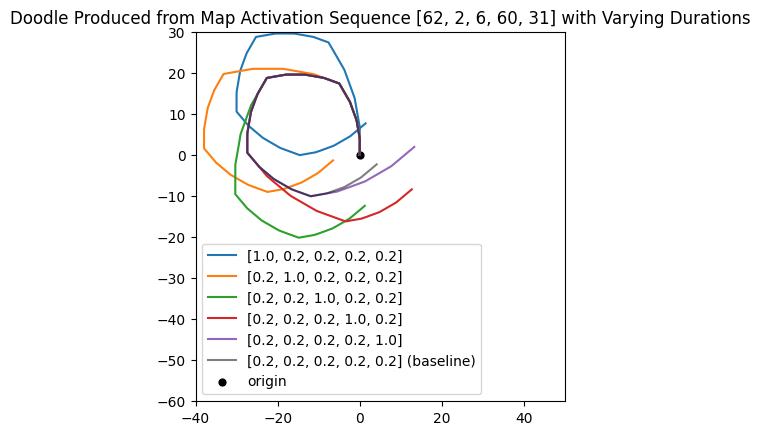

In [37]:
k = 4

f, ax = plt.subplots(1,1)

# ms = [2,6]
# ms = [6,2]
# ms = [2,6,31]
ms = [62,2,6,60,31]
# ms = [31,2,6,62,60]
# ms = [2,60,62,6,31]

code_dict = {}

dur_dict = {1: [1.0,0.2,0.2,0.2,0.2],
            2: [0.2,1.0,0.2,0.2,0.2],
            3: [0.2,0.2,1.0,0.2,0.2],
            4: [0.2,0.2,0.2,1.0,0.2],
            5: [0.2,0.2,0.2,0.2,1.0]
            }

dur_dict[0] = [0.2] * len(ms)

c_merged = np.zeros(crn.ring_layer.num_ring_units)

for dur_idx, dur_vec in dur_dict.items():
    for i, m_idx in enumerate(ms):
        # get top k indexes from current active map neuron
        m = crn.map_layer.weights_to_code_from_map[:,m_idx]
        top_k_idxs = np.argpartition(m.squeeze(), -k)[-k:]
        c = np.zeros((crn.ring_layer.num_ring_units))
        c[top_k_idxs] = m[top_k_idxs]

        # store the code vector so we can display it later
        code_dict[m_idx] = c

        # get ring inputs
        ring_input = crn.code_layer.weights_to_ring_from_code @ c
        dur_output = crn.duration_layer.activate(dur_vec[i])
        
        if i == 0:
            # activate the first map neuron
            v_series, z_series, u_series, r_series = activate(crn.ring_layer, ring_input, dur_output, t_max=t_max, t_steps=max_t_steps, cutoff=False, init_state=None)
            
            # store the final state from first map neuron as the next neuron's initial state
            next_init_state = np.array((v_series[:,-1], u_series[:,-1], r_series[:,-1])).reshape(3*crn.ring_layer.num_ring_units)
            
            # create the doodle for the first map neuron, starting at (0,0) on the canvas
            t_steps = z_series.shape[1]
            x_series, y_series = create_drawing(crn.ring_layer, z_series, t_steps, init_point=(0,0))

            # store the next map neuron's initial point
            next_init_point = (x_series[-1], y_series[-1])
        
        else:
            # activate next map neuron in sequence, using last map neuron's final state as the initial state
            v_series, z_series, u_series, r_series = activate(crn.ring_layer, ring_input, dur_output, t_max=t_max, t_steps=max_t_steps, cutoff=False, init_state=next_init_state)

            # store the final state from first map neuron as the next neuron's initial state 
            next_init_state = np.array((v_series[:,-1], u_series[:,-1], r_series[:,-1])).reshape(3*crn.ring_layer.num_ring_units)

            # create the doodle for the current map neuron, starting at the last map neuron's final point on the canvas
            t_steps = z_series.shape[1]
            x_series_new, y_series_new = create_drawing(crn.ring_layer, z_series, t_steps, init_point=next_init_point)

            x_series_origin, y_series_origin = create_drawing(crn.ring_layer, z_series, t_steps, init_point=(0,0))


            # store the next map neuron's initial point
            next_init_point = (x_series_new[-1], y_series_new[-1])

            # append the current map neuron's x and y series to the whole doodle's series
            x_series = np.hstack((x_series, x_series_new))
            y_series = np.hstack((y_series, y_series_new))

    # PLOT_MINMAX = 15

    # plot entire sequence of doodles
    if dur_idx == 0:
        ax.plot(x_series/2, y_series/2, label=f'{list(dur_vec)} (baseline)', c='black', alpha=0.5)
    else:
        ax.plot(x_series/2, y_series/2, label=f'{list(dur_vec)}')

ax.set_title(f'Doodle Produced from Map Activation Sequence {ms} with Varying Durations')
ax.set_xlim([-40,50])
ax.set_ylim([-60,30])
ax.scatter([0],[0],c='black',s=24,label='origin')
ax.set_box_aspect(1)
ax.legend()


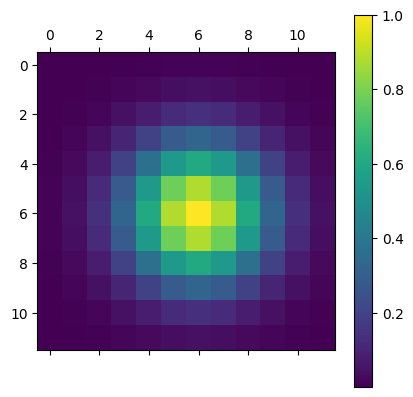

In [45]:
plt.matshow(crn.map_layer.neighborhood(winner=(6,6), sigma=2))
plt.colorbar()